In [1]:
# Importing libraries and packages
import os
import cv2 
import numpy as np
import pandas as pd 
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

from sklearn.model_selection import train_test_split



Using TensorFlow backend.


In [2]:
CUDA_VISIBLE_DEVICES = 1

In [6]:
images = []
label = []

img_path = r'C:\Users\melte\Desktop\ML\Jobs'
listImgs = os.listdir(img_path)


# LOAD IN THE IMAGES
for k in range(0,len(listImgs)):
    img = cv2.imread(('\\'.join([img_path,listImgs[k]])).format(img_path),-1)
    RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if "Anwalt" in listImgs[k]:
        label.append(1)
        images.append(RGB)
    elif "Kfz" in listImgs[k]:
        label.append(0)
        images.append(RGB)
    pass 

n = len(images)

#Create test and train set
X_train, X_test, y_train, y_test = train_test_split(images, label, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

#transform labels to numpy arrays for crosstab: 
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

#number of instances in train, test, val 
n_train = len(X_train)
n_test = len(X_test)
n_val = len(X_val)

In [8]:
import face_recognition

#creating 1x128d feature embeddings from dlibs face_recognition library for train, test and val 
embedding_train = []
embedding_test = []
embedding_val = [] 

for n in range(len(X_train)):
    embedding_train.append(face_recognition.api.face_encodings(X_train[n], known_face_locations=None, num_jitters=10)) 
embedding_train = np.array(embedding_train)

for n in range(len(X_test)):
    embedding_test.append(face_recognition.api.face_encodings(X_test[n], known_face_locations=None, num_jitters=10))
embedding_test = np.array(embedding_test)

for n in range(len(X_val)):
    embedding_val.append(face_recognition.api.face_encodings(X_val[n], known_face_locations=None, num_jitters=10))
embedding_val = np.array(embedding_val)

# #Flatten the embeddings to vectors: 
embedding_train = np.reshape(embedding_train, (n_train, 1*128))
embedding_test = np.reshape(embedding_test, (n_test, 1*128))
embedding_val = np.reshape(embedding_val, (n_val, 1*128))

## SVM Classification 

In [9]:
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.svm import SVC 

SVM = SVC(kernel = 'rbf', gamma='scale', C=20)
SVM.fit(embedding_train, y_train)

train_SVM = SVM.predict(embedding_train)
test_SVM = SVM.predict(embedding_test)
val_SVM = SVM.predict(embedding_val)


print("\nrSVM - Train Confusion Matrix\n\n",
      pd.crosstab(y_train, train_SVM, rownames = ["Actual"], colnames = ["Predicted"]))
print("\nrSVM - Train Accuracy:", round(accuracy_score(y_train, train_SVM),3))
print("\nrSVM - Train Classification Report\n",classification_report(y_train, train_SVM)) 


print("\n\nrSVM - Val Confusion Matrix\n\n",
      pd.crosstab(y_val, val_SVM, rownames = ["Actual"], colnames = ["Predicted"]))
print("\nrSVM - Val Accuracy:", round(accuracy_score(y_val, val_SVM),3))
print("\nrSVM - Test Classification Report\n",classification_report(y_val, val_SVM))

print("\n\nrSVM - Test Confusion Matrix\n\n",
      pd.crosstab(y_test, test_SVM, rownames = ["Actual"], colnames = ["Predicted"]))
print("\nrSVM - Test Accuracy:", round(accuracy_score(y_test, test_SVM),3))
print("\nrSVM - Test Classification Report\n",classification_report(y_test, test_SVM))


rSVM - Train Confusion Matrix

 Predicted   0   1
Actual           
0          33   2
1           7  34

rSVM - Train Accuracy: 0.882

rSVM - Train Classification Report
               precision    recall  f1-score   support

           0       0.82      0.94      0.88        35
           1       0.94      0.83      0.88        41

   micro avg       0.88      0.88      0.88        76
   macro avg       0.88      0.89      0.88        76
weighted avg       0.89      0.88      0.88        76



rSVM - Val Confusion Matrix

 Predicted  0  1
Actual         
0          5  4
1          6  5

rSVM - Val Accuracy: 0.5

rSVM - Test Classification Report
               precision    recall  f1-score   support

           0       0.45      0.56      0.50         9
           1       0.56      0.45      0.50        11

   micro avg       0.50      0.50      0.50        20
   macro avg       0.51      0.51      0.50        20
weighted avg       0.51      0.50      0.50        20



rSVM - Test Co

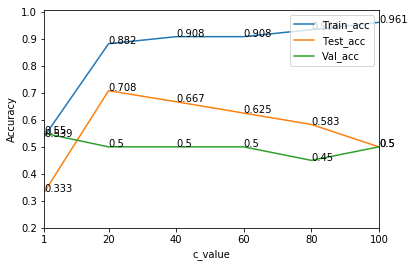

In [10]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, classification_report


array = np.empty((5,4))
k_valchart = pd.DataFrame(array)
k_valchart.columns = ["c_value", "Train_acc", "Val_acc", "Test_acc"]

vals = [1,20,40,60,80,100]

for i in range (len(vals)):
    SVM = SVC(kernel = 'rbf', gamma = 'scale', C=(vals[i]))
    SVM.fit(embedding_train, y_train)
    train_SVM = SVM.predict(embedding_train)
    test_SVM = SVM.predict(embedding_test)
    val_SVM = SVM.predict(embedding_val)
    
    tr_accscore = round(accuracy_score(y_train, train_SVM), 3)
    test_accscore = round(accuracy_score(y_test, test_SVM), 3)
    val_accscore = round(accuracy_score(y_val, val_SVM), 3)
    
    k_valchart.loc[i, 'c_value'] = vals[i]
    k_valchart.loc[i, 'Train_acc'] = tr_accscore
    k_valchart.loc[i, 'Test_acc'] = test_accscore
    k_valchart.loc[i, 'Val_acc'] = val_accscore
    
#PLOTTING ACCURACIES OVER DIFFERENT K VALUES 
plt.figure() 
plt.xlabel('c_value')
plt.ylabel('Accuracy')
plt.plot(k_valchart["c_value"], k_valchart["Train_acc"])
plt.plot(k_valchart["c_value"], k_valchart["Test_acc"])
plt.plot(k_valchart["c_value"], k_valchart["Val_acc"])

plt.axis([0.9, 5, 0.2, 1.005])
plt.xticks([1,20,40,60,80,100])

for a,b in zip(k_valchart["c_value"], k_valchart["Train_acc"]):
    plt.text(a, b, str(b), fontsize = 10)

for a,b in zip(k_valchart["c_value"], k_valchart["Test_acc"]):
    plt.text(a, b, str(b), fontsize = 10)
    
for a,b in zip(k_valchart["c_value"], k_valchart["Val_acc"]):
    plt.text(a, b, str(b), fontsize = 10)
    
plt.legend(loc = 'upper right')
plt.show()

## KNN Clustering

In [ ]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, classification_report


knn_fit = KNeighborsClassifier(n_neighbors = 50, p = 2, metric = 'minkowski')

knn_fit.fit(embedding_train, y_train)

train_res = knn_fit.predict(embedding_train)
val_res = knn_fit.predict(embedding_val)
test_res = knn_fit.predict(embedding_test)
# print(train_res)

print("\nkNN - Train Confusion Matrix\n\n",
      pd.crosstab(y_train, train_res, rownames = ["Actual"], colnames = ["Predicted"]))
print("\nkNN - Train Accuracy:", round(accuracy_score(y_train, train_res),3))
print("\nkNN - Train Classification Report\n",classification_report(y_train, train_res)) 


print("\n\nkNN - Val Confusion Matrix\n\n",
      pd.crosstab(y_val, val_res, rownames = ["Actual"], colnames = ["Predicted"]))
print("\nkNN - Val Accuracy:", round(accuracy_score(y_val, val_res),3))
print("\nkNN - Test Classification Report\n",classification_report(y_val, val_res))

print("\n\nrSVM - Test Confusion Matrix\n\n",
      pd.crosstab(y_test, test_res, rownames = ["Actual"], colnames = ["Predicted"]))
print("\nrSVM - Test Accuracy:", round(accuracy_score(y_test, test_res),3))
print("\nrSVM - Test Classification Report\n",classification_report(y_test, test_res))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, classification_report


array = np.empty((5,4))
k_valchart = pd.DataFrame(array)
k_valchart.columns = ["K_value", "Train_acc", "Test_acc", "Val_acc"]

k_vals = [1,5,10,15,20,30]

for i in range (len(k_vals)):
    knn_fit = KNeighborsClassifier(n_neighbors = k_vals[i], p=2, metric='minkowski')
    knn_fit.fit(embedding_train, y_train)
    tr_accscore = round(accuracy_score(y_train, knn_fit.predict(embedding_train)), 3)
    test_accscore = round(accuracy_score(y_test, knn_fit.predict(embedding_test)), 3)
    val_accscore = round(accuracy_score(y_val, knn_fit.predict(embedding_val)), 3)
    
    k_valchart.loc[i, 'K_value'] = k_vals[i]
    k_valchart.loc[i, 'Train_acc'] = tr_accscore
    k_valchart.loc[i, 'Test_acc'] = test_accscore
    k_valchart.loc[i, 'Val_acc'] = val_accscore
    
#PLOTTING ACCURACIES OVER DIFFERENT K VALUES 
plt.figure() 
plt.xlabel('K_value')
plt.ylabel('Accuracy')
plt.plot(k_valchart["K_value"], k_valchart["Train_acc"])
plt.plot(k_valchart["K_value"], k_valchart["Test_acc"])
plt.plot(k_valchart["K_value"], k_valchart["Val_acc"])

plt.axis([0.9, 5, 0.2, 1.005])
plt.xticks([1,5,10,15,20,30])

for a,b in zip(k_valchart["K_value"], k_valchart["Train_acc"]):
    plt.text(a, b, str(b), fontsize = 10)
    
for a,b in zip(k_valchart["K_value"], k_valchart["Test_acc"]):
    plt.text(a, b, str(b), fontsize = 10)
    
for a,b in zip(k_valchart["K_value"], k_valchart["Val_acc"]):
    plt.text(a, b, str(b), fontsize = 10)
    
plt.legend(loc = 'upper right')
plt.show()